# Visualization of clustering
In this notebook, I'd like to show you my favourite way of visualizing clusters from arbitrary clustering algorithm.

I will work with the Iris dataset from scikit-sklearn. Lates version of Anaconda (I am using Python 2.7) is all you need to run this example.

All suggestions are very much appreciated.

In [1]:
#Imports
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import zscore
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
import seaborn as sns

#Make the print nice
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=100, precision=4,suppress=True)

## Prepare the data
We start with preparing the Iris dataset and inspecting the first few rows.

In [2]:
iris = load_iris()
clmns = iris.feature_names

#Put into DataFrame
df_iris = pd.DataFrame(iris.data, columns = clmns)
df_iris['class'] = iris.target

#Let's have a look at first 5 rows
print df_iris.head(n=5)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  class
0                5.1               3.5                1.4               0.2      0
1                4.9               3.0                1.4               0.2      0
2                4.7               3.2                1.3               0.2      0
3                4.6               3.1                1.5               0.2      0
4                5.0               3.6                1.4               0.2      0


## Calculate the clusters
For the sake of the exercise, I will skip choosing and fine tunning the clustering algorithm and simply use out-of-box k-Means from sklearn.

Of course, we do not want the target class leak into the clustering solution, hence the class is not used to calculate the clusters. Lastly, since k-Means uses Euclidian distance, the data are normalized using z-score (I found out that z-score gives overall the most stable solution).

In [3]:
#########
n_cls = 3
#########

def clusterer(df_,k):
    '''
    Calculates cluster labels given the dataset
    -------------------------------------------
    df_: DataFrame containing the training data
    k: number of clusters
    -------------------------------------------
    '''
    #Normalize
    df_std = df_.apply(zscore).as_matrix()
    #Fit the algorithm
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(df_std)
    return cluster_labels 

df_iris['clusters'] = clusterer(df_iris[clmns],n_cls)

## Analyzing the output
Now the interesting part. Every record has a cluster label. In this step, I calculate mean over each column for each cluster. Moreover, I also add mean of each column from the whole sample - this will serve as a benchmark.

In [4]:
def calcClusterFrame(df_, clmn, target_name):
    '''
    Calculates mean for each attribute in each cluster group in order to be easily comparable.
    Moreover, average in the whole sample is added as a benchmark
    -------------------------------------------
    clmn: list of columns
    target_name: name of target column
    df_: DataFrame with input data
    ----------------------------------------'''
    #Calculates mean over all samples
    clmns1 = list(clmn)  
    clmns1.extend([target_name])
    df_sample = pd.DataFrame()
    df_sample['sample_val'] = df_[clmns1].mean(axis=0)
    
    #Calculates mean per cluster
    clmns2 = list(clmns1) 
    clmns2.extend(['clusters'])
    df_clusters = df_[clmns2].groupby(['clusters']).mean().transpose()
    
    #Size of clusters in percentage
    df_clusters.loc['SIZE'] = (df_[clmns2].groupby('clusters')['clusters'].count()/len(df_))*100
    
    #Merge the two DataFrames into one and round
    df_analysis = pd.concat([df_sample['sample_val'],df_clusters], axis=1, join='outer').round(2)
    
    #Set column names
    clmn_names = ['sample_val']
    for clus in np.unique(df_['clusters']):
        clmn_names.append('Cluster_' + str(clus))
        
    df_analysis.columns = clmn_names
    
    #Add count of the whole sample
    df_analysis.loc['SIZE', 'sample_val'] = len(df_)
    
    return df_analysis

If you look at the output, you can easily see the differences between clusters. I have also added size of the whole sample and of each cluster (in percentage). 

Note that in these settings, the mean of the target variable *class* **does not really make sense**. However, when the target is binary, it is very useful. Therefore, I kept it in order to show the possibility.

In [5]:
df_agg = calcClusterFrame(df_iris, clmns, 'class')
print df_agg

                   sample_val  Cluster_0  Cluster_1  Cluster_2
SIZE                   150.00      34.67      33.33      32.00
class                    1.00       1.27       0.00       1.75
petal length (cm)        3.76       4.37       1.46       5.49
petal width (cm)         1.20       1.42       0.24       1.96
sepal length (cm)        5.84       5.79       5.01       6.78
sepal width (cm)         3.05       2.67       3.42       3.09


## Visualizing the output
We have the aggregated table, which does the job, but you would not show this to your boss (I hope). We need to put some fancy colors and make it good-looking!

Just a few notes:
  * argument *prc_clmn* allows to format certain columns as a percentage. This can be useful if any of the input feature is boolean, because then the average is in fact percentage
  * I also added arguments *dire* and *size*, because sometimes I want to visualize different kinds of DataFrames. Those two parameters allows me to be more flexible

In [6]:
def clusterHeatMap(df, clmn, prc_clmn, dire='column', width='5', length='5', color='Blues', size=False):
    """Plot a heatmap from the aggregated dataframe
    --------------------------------------------------------------
    df: Dataframe which we would like to make nice
    clmn: list of columns (in case i need to rename them or make them more readable for business people)
    prc_clmn: list of columns which should be formatted as percentage. If none, just put []
    dire: how the standardization should be - per row or column
    width and length: width and length of the plot
    color: What kind of color I want, its cmap argument so many arguments are possible
    size: whether SIZE row is present and should be formatted
    --------------------------------------------------------------"""
    #Scale the data to have the heatmap 
    scaler = prep.MinMaxScaler()
    mat = df.as_matrix()
    
    if dire =='row':
        scale_t = scaler.fit_transform(mat.T).T
    if dire == 'column':
        scale_t = scaler.fit_transform(mat)
        
    df_std = pd.DataFrame(scale_t, columns=list(df.columns.values), index=df.index)
    
    #Percentage formatting    
    # get positions of columns to be converted to percentage
    idx_position = []
    if prc_clmn:
        for col in prc_clmn:
            try:
                idx_position.append(df.index.get_loc(col))
            except:
                print 'Column {} is not in the DataFrame'.format(col)
    
    # format every row depending whether it should be % or not        
    labels_char = []
    for rowid,row in enumerate(mat):
        aux = []
        for ele in row:
            if rowid in idx_position:
                aux.append('{:.2f}%'.format(ele*100))
            else:
                aux.append('{:.2f}'.format(ele))
        labels_char.append(aux)
    
    #Format SIZE for cluster heatmaps
    idx = df.index.tolist()
    if size:
        position = idx.index('SIZE')
        for i,ele in enumerate(labels_char[position]):
            if i > 0:
                labels_char[0][i] = '{:.2f}%'.format(np.float(ele))
        
    #needs to be in numpy in order to pass it as a parameter to seaborn
    labels_char = np.array(labels_char)
            
    #Plot and its formatting
    fig, ax = plt.subplots(figsize=(width,length))
    ax = sns.heatmap(df_std, annot=labels_char, fmt = '', cmap=color) #fmt must be set to '' when working with str
    ax.set_xticklabels(clmn, minor=False) #custom names with breaks
    ax.xaxis.tick_top() #move on top

Below you can see the visualization. I really like this because with a quick look, I can tell:

  1. size of each group
  2. difference between attributes in clusters
  3. comparison with the whole dataset


**In our case:**
  * The groups have approximately same size.
  * cluster_1 contains mostly class 0, whilst cluster_2 have more class 2 and 3 (again, only example - mean for categorical values really does not make sense)
  * Flowers in cluster_0 have the lowest sepal width, other attributes are above average.
  * Flowers in cluster_1 have the highest sepal width, other features are below average.
  * Flowers in cluster_2 seems to be the largest with exception of sepal width.
  * Cluster_0 and cluster_2 are quite similar.

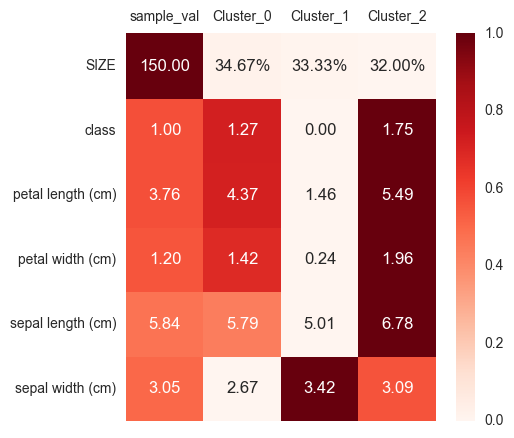

In [7]:
clusterHeatMap(df_agg, df_agg.columns, [], dire='row', width=5, length=5, color='Reds', size=True)
plt.show();